In [11]:
!pip install datasets transformers huggingface_hub
!apt-get install git-lfs
!pip install accelerate -U
!pip install transformers[torch]
!pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
!pip install evaluate
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 493.7/493.7 kB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 34.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 32.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 14.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 17.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 43.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 52.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 30.4 MB/s eta 0:00:00
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
git-lfs is already the newest version (3.0.2-1ubuntu0.2).
0 upgraded, 0 newly installed, 0 to remove and 18 not upgraded.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.1/258.1 kB 4.1 MB/s eta 0:00:00
Looking in indexes: https://download.pytorch.org

In [4]:
import pandas as pd
import numpy as np
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
import sklearn
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import tensorflow as tf

import torch
torch.cuda.is_available()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [7]:
df = pd.read_csv("IMDB Dataset.csv",sep=",")
df

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative


In [8]:
sentiment_counts = df['sentiment'].value_counts()
print(sentiment_counts)

positive    25000
negative    25000
Name: sentiment, dtype: int64


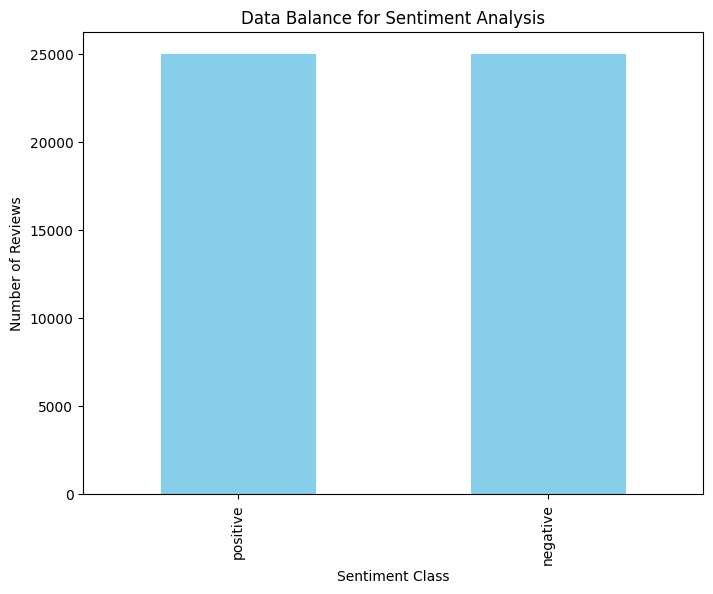

In [9]:
plt.figure(figsize=(8, 6))
sentiment_counts.plot(kind='bar', color='skyblue')
plt.title('Data Balance for Sentiment Analysis')
plt.xlabel('Sentiment Class')
plt.ylabel('Number of Reviews')
plt.show()

In [10]:
df = df.drop_duplicates()

In [11]:
df.isnull().any()

review       False
sentiment    False
dtype: bool

In [9]:
df = df.apply(lambda x: x.astype(str).str.lower() if x.dtype == "object" else x)

In [12]:
df["review"] = df["review"].str.replace('[^a-zA-Z0-9 ]','')
df["review"] = df["review"].str.replace('br','')
df['sentiment'] = df['sentiment'].replace({'positive': 0, 'negative': 1})
df

<ipython-input-12-cbc4437aef19>:1: FutureWarning: The default value of regex will change from True to False in a future version.
  df["review"] = df["review"].str.replace('[^a-zA-Z0-9 ]','')
<ipython-input-12-cbc4437aef19>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["review"] = df["review"].str.replace('[^a-zA-Z0-9 ]','')
<ipython-input-12-cbc4437aef19>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["review"] = df["review"].str.replace('br','')
<ipython-input-12-cbc4437aef19>:3: SettingWithCopy

,review,sentiment
0,One of the other reviewers has mentioned that ...,0
1,A wonderful little production The filming te...,0
2,I thought this was a wonderful way to spend ti...,0
3,Basically theres a family where a little boy J...,1
4,Petter Matteis Love in the Time of Money is a ...,0
...,...,...
49995,I thought this movie did a down right good job...,0
49996,Bad plot bad dialogue bad acting idiotic direc...,1
49997,I am a Catholic taught in parochial elementary...,1
49998,Im going to have to disagree with the previous...,1


In [13]:
subset = df.iloc[0:3300]

## Preparations

In [1]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from transformers import TrainingArguments, Trainer
from transformers.optimization import get_scheduler
from sklearn.model_selection import train_test_split
from datasets import load_metric
from sklearn.metrics import roc_curve, roc_auc_score
from transformers import pipeline
import evaluate

In [5]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, tokenizer, texts, labels=None):
        self.encodings = tokenizer(texts, padding=True, truncation=True, max_length=512)
        self.labels = labels
    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        if self.labels:
            item["labels"] = torch.tensor(self.labels[idx])
        return item
    def __len__(self):
        return len(self.encodings["input_ids"])

In [14]:
docs, labels = subset["review"].tolist(), subset["sentiment"].tolist()
X_train, X_test, y_train, y_test = train_test_split(docs, labels, test_size=0.2, random_state=42)

In [15]:
bert_tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')
bert_model = AutoModelForSequenceClassification.from_pretrained('distilbert-base-uncased')

train_docs_dataset = Dataset(bert_tokenizer, X_train, y_train)
eval_docs_dataset = Dataset(bert_tokenizer, X_test, y_test)

batch_size = 8
epochs = 2

weight_decay = 0.01

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [16]:
metric = evaluate.load("accuracy")
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    #########################################
    load_accuracy = load_metric("accuracy")
    load_f1 = load_metric("f1")
    accuracy = load_accuracy.compute(predictions=predictions, references=labels)["accuracy"]
    f1 = load_f1.compute(predictions=predictions, references=labels)["f1"]
    return {"accuracy": accuracy, "f1": f1}
    #########################################

training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=epochs,
    auto_find_batch_size=True,
    evaluation_strategy="epoch",
    weight_decay=weight_decay,
    logging_dir='./logs'
)

In [17]:
trainer = Trainer(
    model=bert_model,
    args=training_args,
    train_dataset=train_docs_dataset,
    eval_dataset=eval_docs_dataset,
    compute_metrics=compute_metrics,
)

In [18]:
trainer.train()
trainer.evaluate()
trainer.save_model("./distilbert_model")

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.411299,0.845455,0.827703
2,0.332500,0.464863,0.892424,0.895126


<ipython-input-16-01c61947d796>:6: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  load_accuracy = load_metric("accuracy")


In [ ]:
model = AutoModelForSequenceClassification.from_pretrained("./distilbert_model")
df_pred = df.iloc[3301:6301]
X_pred = df_pred["review"].to_list()
y_real = df_pred["sentiment"].to_list()

tokenized_input = bert_tokenizer(X_pred, padding=True, truncation=True, return_tensors="pt")

with torch.no_grad():
    outputs = model(**tokenized_input)

predicted_probs = torch.softmax(outputs.logits, dim=1)
predicted_probs = predicted_probs[:, 1].tolist()  # Assuming you want the probability for the 'positive' class

[1 0 1 0 0 1 1 0 1 1]
[1, 0, 1, 0, 0, 1, 1, 0, 1, 1]


In [ ]:
fpr, tpr, thresholds = roc_curve(y_real, predicted_probs)
auc = roc_auc_score(y_real, predicted_probs)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = {:.2f})'.format(auc))
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()